# K-Nearest Neighbours

In this notebook, we will explore classification using the K-Nearest Neighbours approach. We use a customer churn dataset from the telecom industry which includes customer data, usage of long-distance, data usage, monthly revenue, type of offerings, and other services purchased by customers. The data is based on a fictional telecom firm. We are using the subset of customers who have phone accounts. Since the data includes a mix of numeric, categorical, and ordinal variables, we will load this data and do some preprocessing, then use K-Nearest Neighbours to predict customer churn rates.

After going through this notebook, we should have a working understanding of how to preprocess a variety of variables in order to apply the K-Nearest Neighbours algorithm, understand how to choose K, and understand how to evaluate model performance.

# Importing the Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Importing the Dataset

In [2]:
ds = pd.read_pickle('churndata.pkl')

In [3]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 21 columns):
id               7043 non-null object
months           7043 non-null int64
offer            7043 non-null object
phone            7043 non-null object
multiple         7043 non-null object
internet_type    7043 non-null object
gb_mon           7043 non-null int64
security         7043 non-null object
backup           7043 non-null object
protection       7043 non-null object
support          7043 non-null object
unlimited        7043 non-null object
contract         7043 non-null object
paperless        7043 non-null object
payment          7043 non-null object
monthly          7043 non-null float64
total_revenue    7043 non-null float64
satisfaction     7043 non-null int64
churn_value      7043 non-null int64
churn_score      7043 non-null int64
cltv             7043 non-null int64
dtypes: float64(2), int64(6), object(13)
memory usage: 1.2+ MB


In [4]:
ds.head()

,id,months,offer,phone,multiple,internet_type,gb_mon,security,backup,protection,...,unlimited,contract,paperless,payment,monthly,total_revenue,satisfaction,churn_value,churn_score,cltv
0,8779-QRDMV,1,None,No,No,DSL,8,No,No,Yes,...,No,Month-to-Month,Yes,Bank Withdrawal,39.65,59.65,3,1,91,5433
1,7495-OOKFY,8,Offer E,Yes,Yes,Fiber Optic,17,No,Yes,No,...,Yes,Month-to-Month,Yes,Credit Card,80.65,1024.10,3,1,69,5302
2,1658-BYGOY,18,Offer D,Yes,Yes,Fiber Optic,52,No,No,No,...,Yes,Month-to-Month,Yes,Bank Withdrawal,95.45,1910.88,2,1,81,3179
3,4598-XLKNJ,25,Offer C,Yes,No,Fiber Optic,12,No,Yes,Yes,...,Yes,Month-to-Month,Yes,Bank Withdrawal,98.50,2995.07,2,1,88,5337
4,4846-WHAFZ,37,Offer C,Yes,Yes,Fiber Optic,14,No,No,No,...,Yes,Month-to-Month,Yes,Bank Withdrawal,76.50,3102.36,2,1,67,2793


In [5]:
# Notice that the data contains a unique ID, an indicator for phone customer status, 
# total lifetime value, total revenue, and a bank-estimated churn score.
# We will not be using these features, so they can be dropped from the data.

ds = ds.drop(columns=['id', 'phone', 'total_revenue', 'cltv', 'churn_score'])

In [6]:
# Describe the data to 2 dp

round(ds.describe(),2)

,months,gb_mon,monthly,satisfaction,churn_value
count,7043.00,7043.00,7043.00,7043.00,7043.00
mean,32.39,20.52,64.76,3.24,0.27
std,24.54,20.42,30.09,1.20,0.44
min,1.00,0.00,18.25,1.00,0.00
25%,9.00,3.00,35.50,3.00,0.00
50%,29.00,17.00,70.35,3.00,0.00
75%,55.00,27.00,89.85,4.00,1.00
max,72.00,85.00,118.75,5.00,1.00


In [7]:
ds.describe(include = 'object')

,offer,multiple,internet_type,security,backup,protection,support,unlimited,contract,paperless,payment
count,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043
unique,6,2,4,2,2,2,2,2,3,2,3
top,None,No,Fiber Optic,No,No,No,No,Yes,Month-to-Month,Yes,Bank Withdrawal
freq,3877,4072,3035,5024,4614,4621,4999,4745,3610,4171,3909


We will now:
- Identify which variables are binary, categorical and not ordinal, categorical and ordinal, and numeric. The non-numeric features will need to be encoded.
- Start by identifying the number of unique values each variable takes, then create list variables for categorical, numeric, binary, and ordinal variables.
- Examine the values of the other categorical variables to determine which may be encoded ordinally.

**Note:** The variable 'months' can be treated as numeric, but it may be more convenient to transform it to an ordinal variable.

In [8]:
ds_uniques = pd.DataFrame([[i, len(ds[i].unique())] for i in ds.columns], columns=['Variable', 'Unique Values']).set_index('Variable')
ds_uniques

,Unique Values
Variable,
months,72
offer,6
multiple,2
internet_type,4
gb_mon,50
security,2
backup,2
protection,2
support,2


In [9]:
binary_variables = list(ds_uniques[ds_uniques['Unique Values'] == 2].index)
binary_variables

['multiple',
 'security',
 'backup',
 'protection',
 'support',
 'unlimited',
 'paperless',
 'churn_value']

In [10]:
categorical_variables = list(ds_uniques[(6 >= ds_uniques['Unique Values']) & (ds_uniques['Unique Values'] > 2)].index)
categorical_variables

['offer', 'internet_type', 'contract', 'payment', 'satisfaction']

In [11]:
[[i, list(ds[i].unique())] for i in categorical_variables]

[['offer', ['None', 'Offer E', 'Offer D', 'Offer C', 'Offer B', 'Offer A']],
 ['internet_type', ['DSL', 'Fiber Optic', 'Cable', 'None']],
 ['contract', ['Month-to-Month', 'One Year', 'Two Year']],
 ['payment', ['Bank Withdrawal', 'Credit Card', 'Mailed Check']],
 ['satisfaction', [3, 2, 1, 4, 5]]]

In [12]:
ordinal_variables = ['contract', 'satisfaction']

In [13]:
ds['months'].unique()

array([ 1,  8, 18, 25, 37, 27, 58, 15,  7, 11,  3, 13, 16, 24,  4, 32, 54,
        2, 21, 55,  5, 20, 65, 49, 43, 56, 52, 33, 30, 46,  9, 10, 35, 44,
       62, 14, 12, 17, 39, 68, 34, 22, 19, 23, 42, 41, 57, 38, 29, 66, 69,
       40, 31, 59, 36, 45, 53, 70, 47, 50, 51, 72, 26,  6, 28, 48, 61, 71,
       60, 64, 67, 63])

In [14]:
ordinal_variables.append('months')

In [15]:
numeric_variables = list(set(ds.columns) - set(ordinal_variables) - set(categorical_variables) - set(binary_variables))

In [16]:
numeric_variables

['monthly', 'gb_mon']

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a1d803f98>,
      dtype=object)

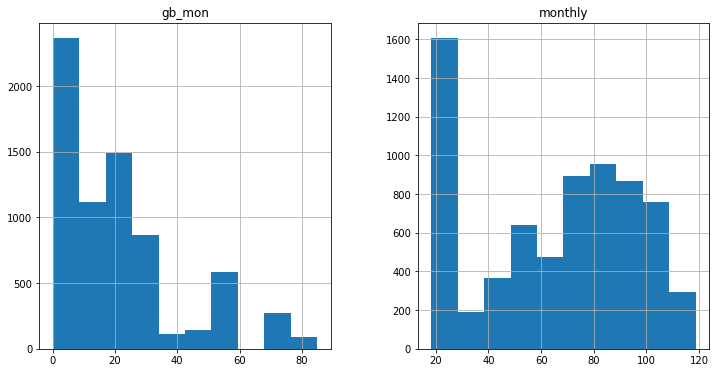

In [17]:
ds[numeric_variables].hist(figsize=(12, 6))

In [18]:
# When using cut, 
ds['months'] = pd.cut(ds['months'], bins=5)

In [19]:
ds['months']

0       (0.929, 15.2]
1       (0.929, 15.2]
2        (15.2, 29.4]
3        (15.2, 29.4]
4        (29.4, 43.6]
            ...      
7038     (57.8, 72.0]
7039     (15.2, 29.4]
7040     (57.8, 72.0]
7041    (0.929, 15.2]
7042     (57.8, 72.0]
Name: months, Length: 7043, dtype: category
Categories (5, interval[float64]): [(0.929, 15.2] < (15.2, 29.4] < (29.4, 43.6] < (43.6, 57.8] < (57.8, 72.0]]

# Feature Scaling

We will now:

- Feature Scale: Having set up the variables, remember that the K-Nearest Neighbours algorithm uses distance and hence requires scaled data.
- Save the processed dataframe as a comma-separated file: 'churndata_processed.csv'

In [20]:
from sklearn.preprocessing import LabelBinarizer, LabelEncoder, OrdinalEncoder

In [21]:
lb, le = LabelBinarizer(), LabelEncoder()

In [22]:
for column in ordinal_variables:
    ds[column] = le.fit_transform(ds[column])

In [23]:
ds[ordinal_variables].astype('category').describe()

,contract,satisfaction,months
count,7043,7043,7043
unique,3,5,5
top,0,2,0
freq,3610,2665,2470


In [24]:
for column in binary_variables:
    ds[column] = lb.fit_transform(ds[column])

In [25]:
categorical_variables = list(set(categorical_variables) - set(ordinal_variables))

In [26]:
# drop_first is used to avoid the dummy variable trap

ds = pd.get_dummies(ds, columns = categorical_variables, drop_first=True)

In [27]:
ds.describe().T

,count,mean,std,min,25%,50%,75%,max
months,7043.0,1.734204,1.592924,0.00,0.0,1.00,3.00,4.00
multiple,7043.0,0.421837,0.493888,0.00,0.0,0.00,1.00,1.00
gb_mon,7043.0,20.515405,20.418940,0.00,3.0,17.00,27.00,85.00
security,7043.0,0.286668,0.452237,0.00,0.0,0.00,1.00,1.00
backup,7043.0,0.344881,0.475363,0.00,0.0,0.00,1.00,1.00
protection,7043.0,0.343888,0.475038,0.00,0.0,0.00,1.00,1.00
support,7043.0,0.290217,0.453895,0.00,0.0,0.00,1.00,1.00
unlimited,7043.0,0.673719,0.468885,0.00,0.0,1.00,1.00,1.00
contract,7043.0,0.754792,0.848468,0.00,0.0,0.00,2.00,2.00
paperless,7043.0,0.592219,0.491457,0.00,0.0,1.00,1.00,1.00


In [28]:
from sklearn.preprocessing import MinMaxScaler
mm = MinMaxScaler()

In [29]:
for column in [ordinal_variables + numeric_variables]:
    ds[column] = mm.fit_transform(ds[column])

In [30]:
round(ds.describe().T, 3)

,count,mean,std,min,25%,50%,75%,max
months,7043.0,0.434,0.398,0.0,0.000,0.250,0.750,1.0
multiple,7043.0,0.422,0.494,0.0,0.000,0.000,1.000,1.0
gb_mon,7043.0,0.241,0.240,0.0,0.035,0.200,0.318,1.0
security,7043.0,0.287,0.452,0.0,0.000,0.000,1.000,1.0
backup,7043.0,0.345,0.475,0.0,0.000,0.000,1.000,1.0
protection,7043.0,0.344,0.475,0.0,0.000,0.000,1.000,1.0
support,7043.0,0.290,0.454,0.0,0.000,0.000,1.000,1.0
unlimited,7043.0,0.674,0.469,0.0,0.000,1.000,1.000,1.0
contract,7043.0,0.377,0.424,0.0,0.000,0.000,1.000,1.0
paperless,7043.0,0.592,0.491,0.0,0.000,1.000,1.000,1.0


In [31]:
# Save a copy of the processed data for later use

outputfile = 'ChurnData_Processed.csv'
ds.to_csv(outputfile, index=False)

Next steps:
    
- Now that the data are encoded and scaled, we will separate the features (X) from the target (y, churn_value).
- Split the sample into training and test samples, with the test sample representing 40% of observations.
- Estimate a K-Nearest Neighbors model, using K=3.
- Examine the Precision, Recall, F-1 Score, and Accuracy of the classification.

In [32]:
# Importing the libraries

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, f1_score

In [33]:
# Set up X and y variables

y, X = ds['churn_value'], ds.drop(columns='churn_value')

# Split the data into training and test samples

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

In [34]:
# Estimate KNN model and report outcomes

knn = KNeighborsClassifier(n_neighbors=3)
knn = knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

# Preciision, recall, f-score from the multi-class support function

print(classification_report(y_test, y_pred))
print('Accuracy score: ', round(accuracy_score(y_test, y_pred), 2))
print('F1 Score: ', round(f1_score(y_test, y_pred), 2))

              precision    recall  f1-score   support

           0       0.90      0.92      0.91      2048
           1       0.77      0.72      0.74       770

    accuracy                           0.86      2818
   macro avg       0.83      0.82      0.82      2818
weighted avg       0.86      0.86      0.86      2818

Accuracy score:  0.86
F1 Score:  0.74


In [35]:
# Plot confusion matrix

confusion_matrix(y_test, y_pred)

array([[1880,  168],
       [ 216,  554]])

- Let's use K=5 and weight the results by distance.
- Let's examine the Precision, Recall, F-1 Score, and Accuracy of the classification, and visualize the Confusion Matrix.

In [36]:
knn = KNeighborsClassifier(n_neighbors=5, weights='distance')
knn = knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

# Precision, recall, f-score from the multi-class support function

print(classification_report(y_test, y_pred))
print('Accuracy score:', round(accuracy_score(y_test, y_pred), 2))
print('F1 Score:', round(f1_score(y_test, y_pred), 2))

              precision    recall  f1-score   support

           0       0.91      0.92      0.91      2048
           1       0.78      0.74      0.76       770

    accuracy                           0.87      2818
   macro avg       0.84      0.83      0.84      2818
weighted avg       0.87      0.87      0.87      2818

Accuracy score: 0.87
F1 Score: 0.76


In [37]:
# Plotting the confusion matrix

confusion_matrix(y_test, y_pred)

array([[1889,  159],
       [ 197,  573]])

- Let's try to determine the right value for K, examing results for values of K from 1 to 40.
- This time, we will focus on two measures, the F-1 Score, and the Error Rate (1-Accuracy)

In [38]:
max_k = 40
f1_scores = list()
error_rates = list() # 1-accuracy

for k in range(1, max_k):
    
    knn = KNeighborsClassifier(n_neighbors=k, weights='distance')
    knn = knn.fit(X_train, y_train)
    
    y_pred = knn.predict(X_test)
    f1 = f1_score(y_pred, y_test)
    f1_scores.append((k, round(f1_score(y_test, y_pred), 4)))
    error = 1-round(accuracy_score(y_test, y_pred), 4)
    error_rates.append((k, error))
    
f1_results = pd.DataFrame(f1_scores, columns=['K', 'F1 Score'])
error_results = pd.DataFrame(error_rates, columns=['K', 'Error Rate'])

<Figure size 1800x1200 with 0 Axes>

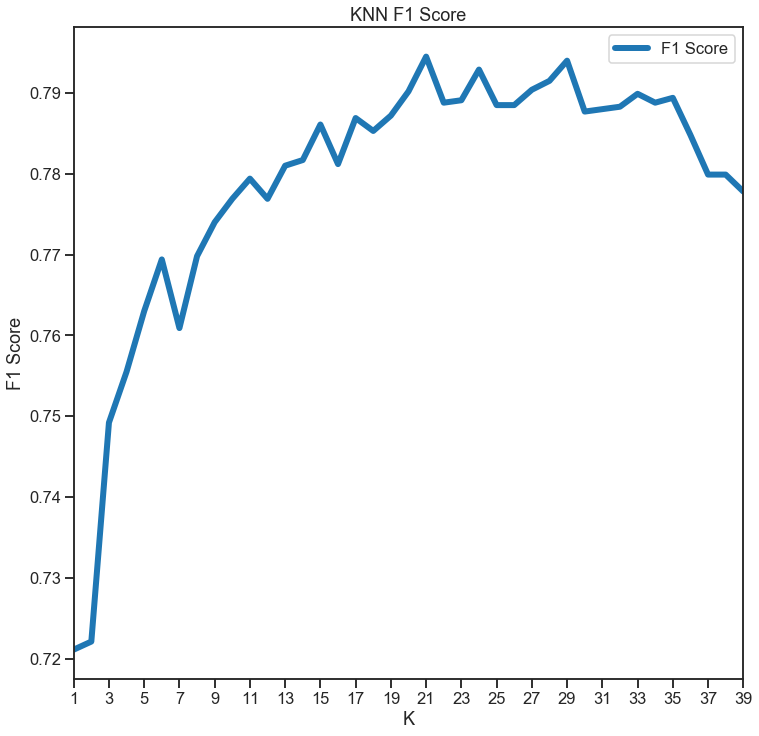

In [39]:
# Plot F1 results

sns.set_context('talk')
sns.set_style('ticks')

plt.figure(dpi=300)
ax = f1_results.set_index('K').plot(figsize=(12, 12), linewidth=6)
ax.set(xlabel='K', ylabel='F1 Score')
ax.set_xticks(range(1, max_k, 2));
plt.title('KNN F1 Score')
plt.savefig('knn_f1.png')

<Figure size 1800x1200 with 0 Axes>

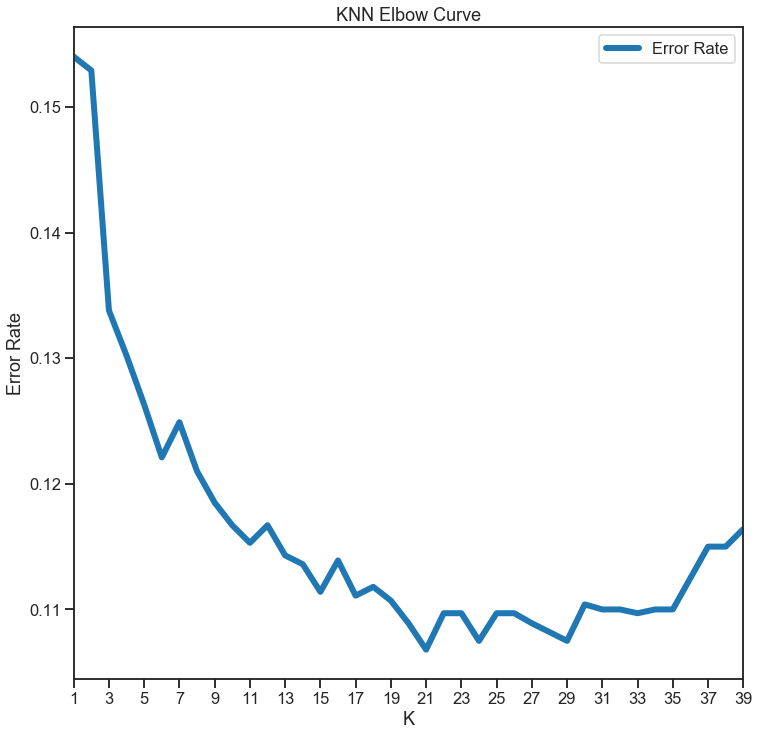

In [40]:
# Plot Accuracy (Error Rate) results
sns.set_context('talk')
sns.set_style('ticks')

plt.figure(dpi=300)
ax = error_results.set_index('K').plot(figsize=(12, 12), linewidth=6)
ax.set(xlabel='K', ylabel='Error Rate')
ax.set_xticks(range(1, max_k, 2))
plt.title('KNN Elbow Curve')
plt.savefig('knn_elbow.png')